# 00 - Estrazione Keypoints per Weak Supervision

Questo notebook estrae i **24 keypoints anatomici del cane** dai dataset per il training del **Stray Pose Classifier**.

## IMPORTANTE: Modello Dog-Pose

**PREREQUISITO**: Prima di eseguire questo notebook, assicurati di aver:
1. Eseguito `00a_yolo_dog_pose_training.ipynb` per addestrare il modello dog-pose
2. Oppure avere `yolo11n-dog-pose.pt` nella cartella `backend/weights/`

Il modello `yolo11n-pose.pt` standard rileva solo **PERSONE** (17 keypoints umani).
Per rilevare **CANI** serve il modello dog-pose che estrae **24 keypoints anatomici**.

## Approccio Weak Supervision

- **Label = 1 (Stray)**: Keypoints estratti dal FYP Dataset (cani randagi)
- **Label = 0 (Owned)**: Keypoints estratti da Stanford Dogs (cani padronali)

Nessuna annotazione manuale richiesta - i label derivano dall'origine del dataset.

## Keypoints del Cane (24)

```
 0: nose            8: withers           16: right_back_elbow
 1: left_eye        9: left_front_elbow  17: left_back_knee
 2: right_eye      10: right_front_elbow 18: right_back_knee
 3: left_ear_base  11: left_front_knee   19: left_back_paw
 4: right_ear_base 12: right_front_knee  20: right_back_paw
 5: left_ear_tip   13: left_front_paw    21: tail_start
 6: right_ear_tip  14: right_front_paw   22: tail_end
 7: throat         15: left_back_elbow   23: chin
```

In [1]:
# Installazione dipendenze
%pip install ultralytics torch torchvision numpy pandas tqdm scipy matplotlib seaborn -q


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import json
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Ultralytics YOLO
from ultralytics import YOLO

# Per Stanford Dogs .mat files
from scipy.io import loadmat

print(f"Python: {sys.version}")

Python: 3.13.7 (main, Aug 14 2025, 11:12:11) [Clang 17.0.0 (clang-1700.0.13.3)]


In [ ]:
# Configurazione paths - RELATIVI per portabilità
# Struttura attesa:
#   BASE_DIR/
#     ├── ResQPet/              (PROJECT_DIR)
#     │   ├── training/notebooks/  (questo notebook)
#     │   ├── backend/weights/
#     │   └── data/keypoints/
#     ├── stray-dogs-detection/fypdataset/  (FYP Dataset - stray dogs)
#     ├── Stanford Dog/                      (Stanford Dogs - owned)
#     └── Dog's skin diseases/               (Skin dataset - owned)

NOTEBOOK_DIR = Path.cwd()

# Trova PROJECT_DIR (ResQPet)
if NOTEBOOK_DIR.name == "notebooks":
    PROJECT_DIR = NOTEBOOK_DIR.parent.parent
elif NOTEBOOK_DIR.name == "training":
    PROJECT_DIR = NOTEBOOK_DIR.parent
elif NOTEBOOK_DIR.name == "ResQPet":
    PROJECT_DIR = NOTEBOOK_DIR
else:
    PROJECT_DIR = NOTEBOOK_DIR
    while PROJECT_DIR.name != "ResQPet" and PROJECT_DIR.parent != PROJECT_DIR:
        PROJECT_DIR = PROJECT_DIR.parent
    if PROJECT_DIR.name != "ResQPet":
        raise ValueError("Impossibile trovare la directory ResQPet. Esegui il notebook dalla cartella corretta.")

# BASE_DIR contiene ResQPet e i dataset
BASE_DIR = PROJECT_DIR.parent

# Dataset paths (relativi a BASE_DIR)
FYP_DATASET = BASE_DIR / "stray-dogs-detection" / "fypdataset"
STANFORD_DOGS = BASE_DIR / "Stanford Dog"
SKIN_DATASET = BASE_DIR / "Dog's skin diseases"

# Output directory
OUTPUT_DIR = PROJECT_DIR / "data" / "keypoints"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base Directory: {BASE_DIR}")
print(f"Project Directory: {PROJECT_DIR}")
print(f"FYP Dataset: {FYP_DATASET}")
print(f"Stanford Dogs: {STANFORD_DOGS}")
print(f"Skin Dataset: {SKIN_DATASET}")
print(f"Output: {OUTPUT_DIR}")

In [6]:
# Verifica esistenza dataset
print("Verifica dataset...")
print(f"FYP exists: {FYP_DATASET.exists()}")
print(f"Stanford exists: {STANFORD_DOGS.exists()}")

if FYP_DATASET.exists():
    fyp_images = list(FYP_DATASET.glob("**/*.jpg")) + list(FYP_DATASET.glob("**/*.png"))
    print(f"FYP images found: {len(fyp_images)}")

if STANFORD_DOGS.exists():
    stanford_files = list(STANFORD_DOGS.glob("*.mat"))
    print(f"Stanford .mat files: {stanford_files}")

Verifica dataset...
FYP exists: True
Stanford exists: True
FYP images found: 10152
Stanford .mat files: [PosixPath('/Users/vittoriodalfonso/Desktop/FIA/Stanford Dog/test_data.mat'), PosixPath('/Users/vittoriodalfonso/Desktop/FIA/Stanford Dog/train_data.mat')]


## 1. Caricamento Modello YOLO11 Dog Pose

**IMPORTANTE**: Il modello `yolo11n-dog-pose.pt` è necessario per rilevare CANI e estrarre i 24 keypoints anatomici corretti.

Se non hai il modello, esegui prima `00a_yolo_dog_pose_training.ipynb`.

In [ ]:
# Carica YOLO11 Dog Pose model
# IMPORTANTE: Usa il modello dog-pose addestrato, NON yolo11n-pose.pt (human pose)

DOG_POSE_MODEL = PROJECT_DIR / "backend" / "weights" / "yolo11n-dog-pose.pt"

print("Caricamento modello YOLO11 Dog Pose...")

if DOG_POSE_MODEL.exists():
    model = YOLO(str(DOG_POSE_MODEL))
    print(f"✓ Modello dog-pose caricato: {DOG_POSE_MODEL.name}")
    print(f"  Questo modello estrae 24 keypoints anatomici del CANE")
else:
    print(f"⚠️ Modello dog-pose non trovato: {DOG_POSE_MODEL}")
    print(f"  Esegui prima il notebook 00a_yolo_dog_pose_training.ipynb")
    print(f"\n  FALLBACK: Usando yolo11n-pose.pt (ATTENZIONE: rileva PERSONE, non cani!)")
    model = YOLO('yolo11n-pose.pt')
    print(f"  Questo modello estrae solo 17 keypoints UMANI - NON usare in produzione!")

print("Modello caricato!")

In [ ]:
# Test del modello e verifica keypoints
if fyp_images:
    test_img = str(fyp_images[0])
    results = model(test_img, verbose=False)
    
    print(f"Test image: {test_img}")
    print(f"Detections: {len(results[0].boxes) if results[0].boxes is not None else 0}")
    
    if results[0].keypoints is not None:
        num_keypoints = results[0].keypoints.data.shape[1]
        print(f"Keypoints shape: {results[0].keypoints.data.shape}")
        print(f"Num keypoints per detection: {num_keypoints}")
        
        # VERIFICA CRITICA: 24 keypoints = Dog-Pose, 17 keypoints = COCO Human
        print("\n" + "="*60)
        if num_keypoints == 24:
            print("✅ MODELLO CORRETTO: Dog-Pose (24 keypoints anatomici del cane)")
            print("   Le features estratte saranno accurate per il comportamento canino.")
        elif num_keypoints == 17:
            print("⚠️  ATTENZIONE: Stai usando il modello COCO Human Pose (17 keypoints)!")
            print("   Questo modello rileva PERSONE, non cani.")
            print("")
            print("   PROBLEMA: Gli indici dei keypoints sono sbagliati!")
            print("   - kpt_11 in COCO = anca umana, in Dog-Pose = ginocchio anteriore")
            print("   - kpt_15/16 in COCO = caviglie umane, in Dog-Pose = gomiti posteriori")
            print("")
            print("   SOLUZIONE: Esegui prima 00a_yolo_dog_pose_training.ipynb")
            print("              per addestrare il modello sul dataset Dog-Pose.")
            print("")
            print("   Il notebook continuerà, ma le features comportamentali")
            print("   (tail_drop, ear_position, etc.) NON saranno disponibili.")
        else:
            print(f"❓ Numero keypoints inatteso: {num_keypoints}")
        print("="*60)

## 2. Funzioni di Estrazione

In [9]:
def extract_keypoints_from_image(model, image_path, confidence_threshold=0.5):
    """
    Estrae keypoints da un'immagine.
    
    Returns:
        List of dicts con keypoints normalizzati per ogni detection
    """
    try:
        results = model(str(image_path), verbose=False)
        
        extractions = []
        
        for result in results:
            if result.boxes is None or result.keypoints is None:
                continue
                
            for i, (box, kpts) in enumerate(zip(result.boxes, result.keypoints)):
                conf = float(box.conf[0]) if box.conf is not None else 0.0
                
                # Filtra per confidence
                if conf < confidence_threshold:
                    continue
                
                # Estrai bbox
                bbox = box.xyxy[0].cpu().numpy()
                x1, y1, x2, y2 = bbox
                w, h = x2 - x1, y2 - y1
                
                # Estrai e normalizza keypoints
                kpts_data = kpts.data[0].cpu().numpy()  # Shape: (num_kpts, 3)
                
                # Normalizza rispetto alla bbox
                normalized_kpts = kpts_data.copy()
                if w > 0 and h > 0:
                    normalized_kpts[:, 0] = (kpts_data[:, 0] - x1) / w  # x normalizzato
                    normalized_kpts[:, 1] = (kpts_data[:, 1] - y1) / h  # y normalizzato
                    # visibility rimane invariata
                
                extractions.append({
                    'keypoints': normalized_kpts,
                    'keypoints_raw': kpts_data,
                    'bbox': bbox,
                    'confidence': conf,
                    'image_path': str(image_path)
                })
        
        return extractions
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return []


def extract_keypoints_from_dataset(model, image_paths, label, confidence_threshold=0.5):
    """
    Estrae keypoints da un intero dataset.
    
    Args:
        model: YOLO model
        image_paths: Lista di path immagini
        label: 0 (owned) o 1 (stray)
        confidence_threshold: Soglia minima di confidence
    
    Returns:
        DataFrame con tutti i keypoints estratti
    """
    all_extractions = []
    
    for img_path in tqdm(image_paths, desc=f"Extracting (label={label})"):
        extractions = extract_keypoints_from_image(model, img_path, confidence_threshold)
        
        for ext in extractions:
            # Flatten keypoints per il DataFrame
            flat_kpts = ext['keypoints'].flatten()
            
            record = {
                'label': label,
                'confidence': ext['confidence'],
                'image_path': ext['image_path'],
                'bbox_x1': ext['bbox'][0],
                'bbox_y1': ext['bbox'][1],
                'bbox_x2': ext['bbox'][2],
                'bbox_y2': ext['bbox'][3],
            }
            
            # Aggiungi keypoints come colonne separate
            num_kpts = len(ext['keypoints'])
            for k in range(num_kpts):
                record[f'kpt_{k}_x'] = ext['keypoints'][k, 0]
                record[f'kpt_{k}_y'] = ext['keypoints'][k, 1]
                record[f'kpt_{k}_v'] = ext['keypoints'][k, 2]
            
            all_extractions.append(record)
    
    return pd.DataFrame(all_extractions)

## 3. Estrazione da FYP Dataset (Stray Dogs - Label = 1)

In [10]:
# Raccogli immagini dal FYP dataset
fyp_images = []

# Training images
fyp_train = FYP_DATASET / "images" / "training"
if fyp_train.exists():
    fyp_images.extend(list(fyp_train.glob("*.jpg")))
    fyp_images.extend(list(fyp_train.glob("*.png")))

# Anche dalle altre cartelle
for subdir in ["training", "testing", "validation"]:
    subpath = FYP_DATASET / subdir
    if subpath.exists():
        fyp_images.extend(list(subpath.glob("*.jpg")))
        fyp_images.extend(list(subpath.glob("*.png")))

# Rimuovi duplicati
fyp_images = list(set(fyp_images))
print(f"FYP images totali: {len(fyp_images)}")

# Limita per test iniziale (rimuovi questa riga per processare tutto)
# fyp_images = fyp_images[:1000]

FYP images totali: 8121


In [11]:
# Estrai keypoints dal FYP dataset
print("Estrazione keypoints da FYP Dataset (stray dogs)...")
df_stray = extract_keypoints_from_dataset(
    model, 
    fyp_images, 
    label=1,  # Stray
    confidence_threshold=0.5
)

print(f"\nEstrazioni completate: {len(df_stray)} keypoints")
print(df_stray.head())

Estrazione keypoints da FYP Dataset (stray dogs)...


Extracting (label=1): 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8121/8121 [05:56<00:00, 22.80it/s]



Estrazioni completate: 2924 keypoints
   label  confidence                                         image_path  \
0      1    0.503893  /Users/vittoriodalfonso/Desktop/FIA/stray-dogs...   
1      1    0.907209  /Users/vittoriodalfonso/Desktop/FIA/stray-dogs...   
2      1    0.773742  /Users/vittoriodalfonso/Desktop/FIA/stray-dogs...   
3      1    0.680185  /Users/vittoriodalfonso/Desktop/FIA/stray-dogs...   
4      1    0.661831  /Users/vittoriodalfonso/Desktop/FIA/stray-dogs...   

      bbox_x1     bbox_y1     bbox_x2     bbox_y2   kpt_0_x   kpt_0_y  \
0    2.104053    0.000000  578.963135  444.708923  0.522530  0.557264   
1    1.116943   11.099652  283.858429  300.000000  0.480857  0.185256   
2  385.278534  105.373146  443.199829  192.274170  0.467390  0.150411   
3  448.378754   59.021736  488.104645  195.144653  0.366518  0.086995   
4   25.160217   56.588264   59.273422  167.499786  0.343232  0.105233   

    kpt_0_v  ...  kpt_13_v  kpt_14_x  kpt_14_y  kpt_14_v  kpt_15_x  kpt

## 4. Estrazione da Stanford Dogs (Owned Dogs - Label = 0)

Il dataset Stanford Dogs è in formato .mat (MATLAB). Dobbiamo prima estrarre le immagini.

In [12]:
# Funzione per estrarre immagini da Stanford Dogs .mat
def extract_stanford_images(mat_path, output_dir, max_images=None):
    """
    Estrae immagini dal file .mat di Stanford Dogs.
    
    Il formato può variare, questa funzione gestisce i casi più comuni.
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    try:
        data = loadmat(str(mat_path))
        print(f"Keys in .mat file: {data.keys()}")
        
        # Il formato esatto dipende da come è stato salvato
        # Prova diversi formati comuni
        
        image_paths = []
        
        # Formato 1: 'file_list' con path alle immagini
        if 'file_list' in data:
            file_list = data['file_list']
            print(f"Found file_list with {len(file_list)} entries")
            # Questo contiene path, non le immagini stesse
            return None, "file_list contains paths, not images"
        
        # Formato 2: immagini direttamente nel .mat
        if 'images' in data:
            images = data['images']
            print(f"Found images array with shape: {images.shape}")
            
            n_images = min(len(images), max_images) if max_images else len(images)
            
            for i in tqdm(range(n_images), desc="Extracting images"):
                img = images[i]
                if len(img.shape) == 2:  # Grayscale
                    img = np.stack([img]*3, axis=-1)
                
                img_path = output_dir / f"stanford_{i:05d}.jpg"
                plt.imsave(str(img_path), img)
                image_paths.append(img_path)
            
            return image_paths, None
        
        return None, f"Unknown format. Keys: {list(data.keys())}"
        
    except Exception as e:
        return None, str(e)

In [13]:
# Verifica formato Stanford Dogs
stanford_mat_files = list(STANFORD_DOGS.glob("*.mat"))
print(f"Stanford .mat files: {stanford_mat_files}")

if stanford_mat_files:
    # Esamina il primo file
    mat_file = stanford_mat_files[0]
    print(f"\nEsaminando: {mat_file}")
    
    try:
        data = loadmat(str(mat_file))
        print(f"Keys: {[k for k in data.keys() if not k.startswith('__')]}")
        
        for key in data.keys():
            if not key.startswith('__'):
                val = data[key]
                if hasattr(val, 'shape'):
                    print(f"  {key}: shape={val.shape}, dtype={val.dtype}")
                else:
                    print(f"  {key}: type={type(val)}")
    except Exception as e:
        print(f"Error: {e}")

Stanford .mat files: [PosixPath('/Users/vittoriodalfonso/Desktop/FIA/Stanford Dog/test_data.mat'), PosixPath('/Users/vittoriodalfonso/Desktop/FIA/Stanford Dog/train_data.mat')]

Esaminando: /Users/vittoriodalfonso/Desktop/FIA/Stanford Dog/test_data.mat
Keys: ['test_info', 'test_fg_data', 'test_data']
  test_info: shape=(1, 1), dtype=[('file_list', 'O'), ('annotation_list', 'O'), ('labels', 'O'), ('fg_ids', 'O')]
  test_fg_data: shape=(8580, 5376), dtype=float64
  test_data: shape=(8580, 12000), dtype=float64


In [15]:
# Alternativa: usa immagini Stanford Dogs da Kaggle (se disponibili)
# o cerca immagini già estratte nella cartella

stanford_images = []

# Cerca immagini jpg/png nella cartella Stanford
for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPEG', '*.JPG']:
    stanford_images.extend(list(STANFORD_DOGS.glob(f"**/{ext}")))

print(f"Immagini Stanford trovate: {len(stanford_images)}")

# Se non ci sono immagini, suggerisci download da Kaggle
if len(stanford_images) == 0:
    print("\nNessuna immagine trovata nel formato supportato.")
    print("\nOpzioni:")
    print("1. Scarica Stanford Dogs da Kaggle:")
    print("   https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset")
    print("\n2. Usa un dataset alternativo di cani 'owned' (es. da Google Images)")
    print("\n3. Usa solo il Skin Diseases dataset (contiene cani presumibilmente owned)")

Immagini Stanford trovate: 20580


In [16]:
# Alternativa: usa il dataset Skin Diseases come proxy per "owned" dogs
# Questi cani sono stati portati dal veterinario, quindi presumibilmente hanno un proprietario

SKIN_DATASET = BASE_DIR / "Dog's skin diseases"

skin_images = []
if SKIN_DATASET.exists():
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        skin_images.extend(list(SKIN_DATASET.glob(f"**/{ext}")))
    
print(f"Immagini Skin Diseases trovate: {len(skin_images)}")

# Combina con eventuali Stanford images
owned_images = stanford_images + skin_images
print(f"Totale immagini 'owned': {len(owned_images)}")

Immagini Skin Diseases trovate: 4315
Totale immagini 'owned': 24895


In [17]:
# Estrai keypoints dal dataset "owned"
if len(owned_images) > 0:
    print("Estrazione keypoints da dataset 'owned'...")
    
    # Limita per bilanciamento con stray
    max_owned = min(len(owned_images), len(df_stray) * 2)  # Max 2x stray
    owned_sample = owned_images[:max_owned]
    
    df_owned = extract_keypoints_from_dataset(
        model,
        owned_sample,
        label=0,  # Owned
        confidence_threshold=0.5
    )
    
    print(f"\nEstrazioni 'owned' completate: {len(df_owned)} keypoints")
else:
    print("⚠️ Nessuna immagine 'owned' disponibile")
    df_owned = pd.DataFrame()

Estrazione keypoints da dataset 'owned'...


Extracting (label=0): 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5848/5848 [04:07<00:00, 23.62it/s]


Estrazioni 'owned' completate: 1616 keypoints


## 5. Combinazione e Bilanciamento Dataset

In [18]:
# Combina i dataset
print("Combinazione dataset...")
print(f"Stray samples: {len(df_stray)}")
print(f"Owned samples: {len(df_owned)}")

# Concatena
df_combined = pd.concat([df_stray, df_owned], ignore_index=True)
print(f"\nTotale combinato: {len(df_combined)}")

# Statistiche
print(f"\nDistribuzione classi:")
print(df_combined['label'].value_counts())

Combinazione dataset...
Stray samples: 2924
Owned samples: 1616

Totale combinato: 4540

Distribuzione classi:
label
1    2924
0    1616
Name: count, dtype: int64


In [19]:
# Bilanciamento classi (undersampling della classe maggioritaria)
def balance_dataset(df, label_col='label'):
    """
    Bilancia il dataset tramite undersampling.
    """
    counts = df[label_col].value_counts()
    min_count = counts.min()
    
    balanced_dfs = []
    for label in counts.index:
        label_df = df[df[label_col] == label]
        sampled = label_df.sample(n=min_count, random_state=42)
        balanced_dfs.append(sampled)
    
    return pd.concat(balanced_dfs, ignore_index=True).sample(frac=1, random_state=42)

df_balanced = balance_dataset(df_combined)
print(f"Dataset bilanciato: {len(df_balanced)} samples")
print(f"\nDistribuzione:")
print(df_balanced['label'].value_counts())

Dataset bilanciato: 3232 samples

Distribuzione:
label
0    1616
1    1616
Name: count, dtype: int64


In [20]:
# Salva dataset
output_file = OUTPUT_DIR / "pose_keypoints_dataset.csv"
df_balanced.to_csv(output_file, index=False)
print(f"Dataset salvato in: {output_file}")

# Salva anche versione non bilanciata per analisi
df_combined.to_csv(OUTPUT_DIR / "pose_keypoints_full.csv", index=False)
print(f"Dataset completo salvato in: {OUTPUT_DIR / 'pose_keypoints_full.csv'}")

Dataset salvato in: /Users/vittoriodalfonso/Desktop/FIA/ResQPet/data/keypoints/pose_keypoints_dataset.csv
Dataset completo salvato in: /Users/vittoriodalfonso/Desktop/FIA/ResQPet/data/keypoints/pose_keypoints_full.csv


## 6. Visualizzazione e Analisi

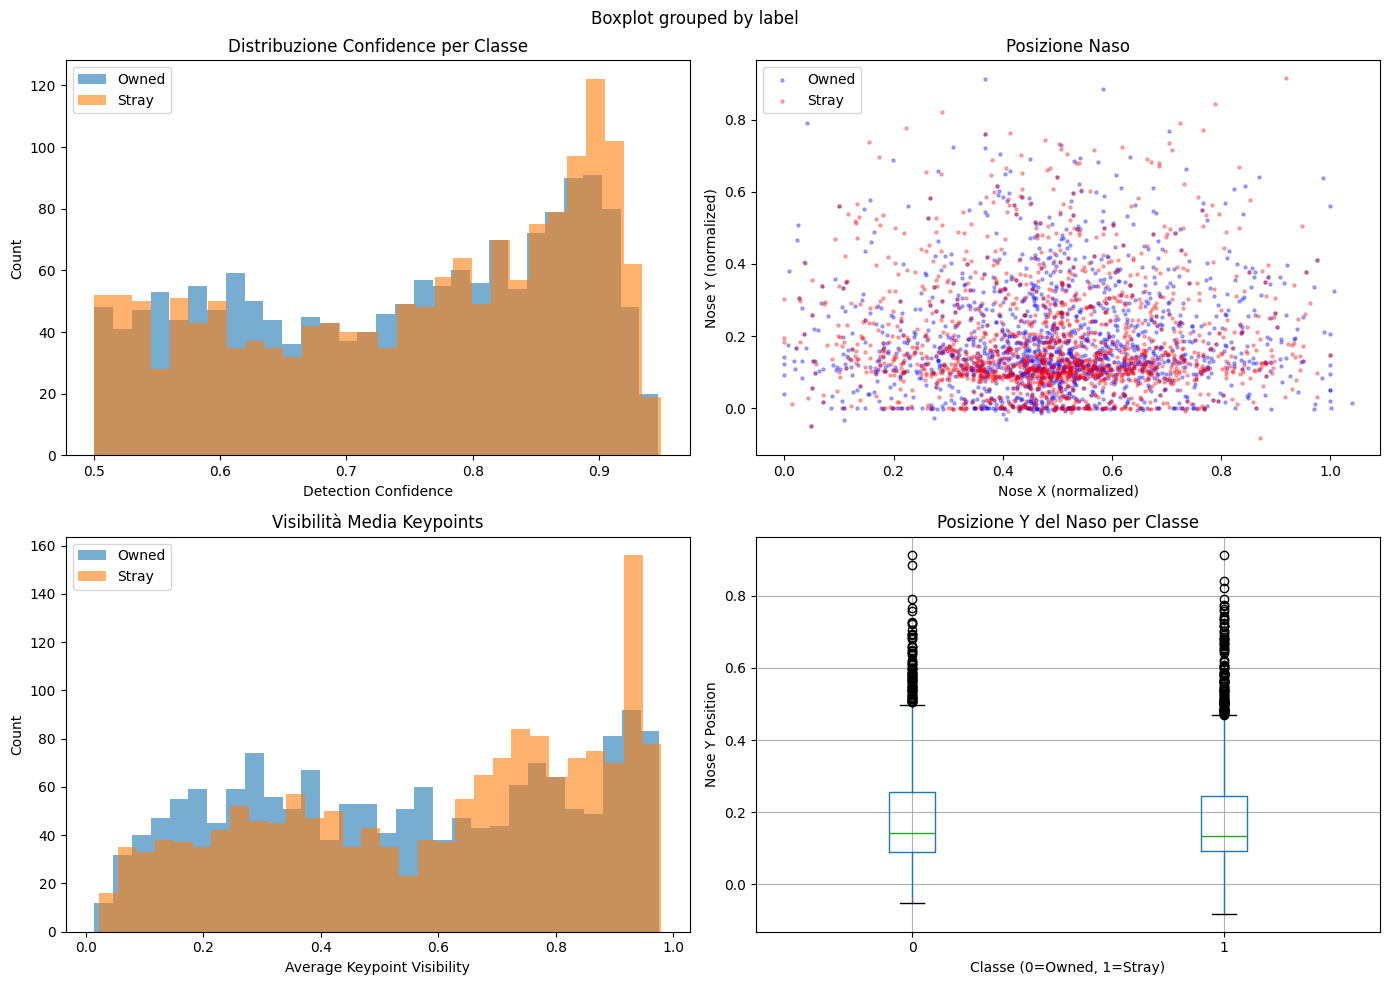

In [21]:
# Visualizza distribuzione keypoints
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribuzione confidence
ax = axes[0, 0]
for label, name in [(0, 'Owned'), (1, 'Stray')]:
    data = df_balanced[df_balanced['label'] == label]['confidence']
    ax.hist(data, bins=30, alpha=0.6, label=name)
ax.set_xlabel('Detection Confidence')
ax.set_ylabel('Count')
ax.set_title('Distribuzione Confidence per Classe')
ax.legend()

# 2. Scatter plot keypoints (esempio: naso x,y)
ax = axes[0, 1]
if 'kpt_0_x' in df_balanced.columns:
    for label, name, color in [(0, 'Owned', 'blue'), (1, 'Stray', 'red')]:
        data = df_balanced[df_balanced['label'] == label]
        ax.scatter(data['kpt_0_x'], data['kpt_0_y'], 
                   alpha=0.3, label=name, c=color, s=5)
    ax.set_xlabel('Nose X (normalized)')
    ax.set_ylabel('Nose Y (normalized)')
    ax.set_title('Posizione Naso')
    ax.legend()

# 3. Distribuzione visibility media
ax = axes[1, 0]
vis_cols = [c for c in df_balanced.columns if c.endswith('_v')]
if vis_cols:
    df_balanced['avg_visibility'] = df_balanced[vis_cols].mean(axis=1)
    for label, name in [(0, 'Owned'), (1, 'Stray')]:
        data = df_balanced[df_balanced['label'] == label]['avg_visibility']
        ax.hist(data, bins=30, alpha=0.6, label=name)
    ax.set_xlabel('Average Keypoint Visibility')
    ax.set_ylabel('Count')
    ax.set_title('Visibilità Media Keypoints')
    ax.legend()

# 4. Box plot di alcune features
ax = axes[1, 1]
if 'kpt_0_y' in df_balanced.columns:
    df_balanced.boxplot(column='kpt_0_y', by='label', ax=ax)
    ax.set_xlabel('Classe (0=Owned, 1=Stray)')
    ax.set_ylabel('Nose Y Position')
    ax.set_title('Posizione Y del Naso per Classe')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "keypoints_analysis.png", dpi=150)
plt.show()

In [22]:
# Statistiche finali
print("="*50)
print("RIEPILOGO ESTRAZIONE KEYPOINTS")
print("="*50)
print(f"\nDataset bilanciato: {len(df_balanced)} samples")
print(f"  - Stray (label=1): {len(df_balanced[df_balanced['label']==1])}")
print(f"  - Owned (label=0): {len(df_balanced[df_balanced['label']==0])}")
print(f"\nNumero keypoints per sample: {len([c for c in df_balanced.columns if c.startswith('kpt_')]) // 3}")
print(f"\nFeatures totali: {len(df_balanced.columns)}")
print(f"\nFile salvati:")
print(f"  - {OUTPUT_DIR / 'pose_keypoints_dataset.csv'}")
print(f"  - {OUTPUT_DIR / 'pose_keypoints_full.csv'}")
print(f"  - {OUTPUT_DIR / 'keypoints_analysis.png'}")

RIEPILOGO ESTRAZIONE KEYPOINTS

Dataset bilanciato: 3232 samples
  - Stray (label=1): 1616
  - Owned (label=0): 1616

Numero keypoints per sample: 17

Features totali: 59

File salvati:
  - /Users/vittoriodalfonso/Desktop/FIA/ResQPet/data/keypoints/pose_keypoints_dataset.csv
  - /Users/vittoriodalfonso/Desktop/FIA/ResQPet/data/keypoints/pose_keypoints_full.csv
  - /Users/vittoriodalfonso/Desktop/FIA/ResQPet/data/keypoints/keypoints_analysis.png


## 7. Preparazione Features per Training

Estrae features interpretabili dai keypoints per il training del MLP.

In [ ]:
def extract_pose_features(row):
    """
    Estrae features comportamentali interpretabili dai 24 keypoints del cane.
    
    KEYPOINTS DOG-POSE (24):
     0: nose            8: withers           16: right_back_elbow
     1: left_eye        9: left_front_elbow  17: left_back_knee
     2: right_eye      10: right_front_elbow 18: right_back_knee
     3: left_ear_base  11: left_front_knee   19: left_back_paw
     4: right_ear_base 12: right_front_knee  20: right_back_paw
     5: left_ear_tip   13: left_front_paw    21: tail_start
     6: right_ear_tip  14: right_front_paw   22: tail_end
     7: throat         15: left_back_elbow   23: chin
    
    Features estratte (indicatori comportamentali stray vs owned):
    - Cani randagi: testa bassa, coda tra le gambe, postura difensiva
    - Cani padronali: testa alta, coda alta, postura rilassata
    """
    features = {}
    
    try:
        # =================================================================
        # FEATURE 1: Head Height (testa bassa = indicatore stray)
        # Altezza del naso rispetto al garrese (withers)
        # =================================================================
        if 'kpt_0_y' in row and 'kpt_8_y' in row:  # nose vs withers
            nose_y = row['kpt_0_y']
            withers_y = row['kpt_8_y']
            # Y aumenta verso il basso, quindi nose_y > withers_y = testa bassa
            # Valore positivo = testa sotto il garrese (indicatore stray)
            features['head_position'] = nose_y - withers_y
        
        # =================================================================
        # FEATURE 2: Tail Position (coda tra le gambe = indicatore stray)
        # Confronta posizione Y della coda con il corpo
        # =================================================================
        if 'kpt_21_y' in row and 'kpt_22_y' in row and 'kpt_8_y' in row:
            tail_start_y = row['kpt_21_y']  # Base della coda
            tail_end_y = row['kpt_22_y']    # Punta della coda
            withers_y = row['kpt_8_y']
            
            # Coda tra le gambe: tail_end_y > tail_start_y (punta più in basso)
            # Coda alta: tail_end_y < tail_start_y
            features['tail_drop'] = tail_end_y - tail_start_y
            
            # Altezza coda rispetto al corpo
            features['tail_height'] = withers_y - tail_start_y
        
        # =================================================================
        # FEATURE 3: Ear Position (orecchie indietro = indicatore stray)
        # Distanza tra base e punta delle orecchie
        # =================================================================
        if all(f'kpt_{i}_x' in row for i in [3, 4, 5, 6]):
            left_ear_base_y = row['kpt_3_y']
            left_ear_tip_y = row['kpt_5_y']
            right_ear_base_y = row['kpt_4_y']
            right_ear_tip_y = row['kpt_6_y']
            
            # Orecchie abbassate: tip più in basso della base
            left_ear_drop = left_ear_tip_y - left_ear_base_y
            right_ear_drop = right_ear_tip_y - right_ear_base_y
            features['ear_drop'] = (left_ear_drop + right_ear_drop) / 2
            
            # Larghezza orecchie (orecchie indietro = più strette)
            features['ear_width'] = abs(row['kpt_5_x'] - row['kpt_6_x'])
        
        # =================================================================
        # FEATURE 4: Body Curl (corpo rannicchiato = indicatore stray)
        # Rapporto tra lunghezza e altezza del corpo
        # =================================================================
        if 'kpt_0_x' in row and 'kpt_21_x' in row:  # nose to tail_start
            body_length_x = abs(row['kpt_21_x'] - row['kpt_0_x'])
            features['body_length'] = body_length_x
        
        if 'kpt_8_y' in row and 'kpt_13_y' in row:  # withers to front_paw
            body_height = abs(row['kpt_13_y'] - row['kpt_8_y'])
            features['body_height'] = body_height
            
            # Corpo rannicchiato = basso rapporto length/height
            if body_height > 0.01 and 'body_length' in features:
                features['body_curl_ratio'] = features['body_length'] / body_height
        
        # =================================================================
        # FEATURE 5: Stance Width (postura difensiva = gambe larghe/strette)
        # Distanza tra le zampe anteriori e posteriori
        # =================================================================
        if 'kpt_13_x' in row and 'kpt_14_x' in row:  # front paws
            features['front_stance_width'] = abs(row['kpt_14_x'] - row['kpt_13_x'])
        
        if 'kpt_19_x' in row and 'kpt_20_x' in row:  # back paws
            features['back_stance_width'] = abs(row['kpt_20_x'] - row['kpt_19_x'])
        
        # =================================================================
        # FEATURE 6: Chin Position (mento nascosto = indicatore stray)
        # Cani impauriti tengono il mento basso/nascosto
        # =================================================================
        if 'kpt_23_y' in row and 'kpt_0_y' in row:  # chin vs nose
            features['chin_tuck'] = row['kpt_23_y'] - row['kpt_0_y']
        
        # =================================================================
        # FEATURE 7: Eye Symmetry (stress = asimmetria)
        # =================================================================
        if 'kpt_1_y' in row and 'kpt_2_y' in row:
            features['eye_symmetry'] = abs(row['kpt_1_y'] - row['kpt_2_y'])
        
        # =================================================================
        # FEATURE 8: Average Keypoint Visibility
        # Cani impauriti nascondono parti del corpo (bassa visibility)
        # =================================================================
        vis_cols = [c for c in row.index if c.endswith('_v')]
        if vis_cols:
            features['avg_visibility'] = np.mean([row[c] for c in vis_cols])
            
            # Visibility delle parti "nascoste" quando impauriti
            tail_vis_cols = ['kpt_21_v', 'kpt_22_v']
            if all(c in row.index for c in tail_vis_cols):
                features['tail_visibility'] = np.mean([row[c] for c in tail_vis_cols])
        
        # =================================================================
        # FEATURE 9: Throat Exposure (gola esposta = cane rilassato)
        # Cani impauriti proteggono la gola
        # =================================================================
        if 'kpt_7_y' in row and 'kpt_0_y' in row:  # throat vs nose
            features['throat_exposure'] = row['kpt_7_y'] - row['kpt_0_y']
        
        # =================================================================
        # FEATURE 10: Overall Posture Score
        # Combinazione di indicatori per postura difensiva
        # =================================================================
        if 'kpt_8_y' in row and 'kpt_13_y' in row and 'kpt_0_y' in row:
            # Quanto il cane è "accovacciato"
            withers_height = row['kpt_8_y']
            paw_height = row['kpt_13_y']
            nose_height = row['kpt_0_y']
            
            # Postura bassa = garrese vicino alle zampe
            if paw_height > 0.01:
                features['crouch_factor'] = withers_height / paw_height
            
    except Exception as e:
        pass
    
    return pd.Series(features)

# Applica estrazione features
print("Estrazione features comportamentali (Dog-Pose 24 keypoints)...")
print("\nNOTA: Se il modello usa solo 17 keypoints (COCO human),")
print("      alcune features non saranno disponibili.")
print("      Assicurati di usare yolo11n-dog-pose.pt!\n")

features_df = df_balanced.apply(extract_pose_features, axis=1)
df_with_features = pd.concat([df_balanced, features_df], axis=1)

print(f"Features estratte: {list(features_df.columns)}")
print(f"Features con valori: {features_df.notna().sum().to_dict()}")

# Salva
df_with_features.to_csv(OUTPUT_DIR / "pose_keypoints_with_features.csv", index=False)
print(f"\nSalvato in: {OUTPUT_DIR / 'pose_keypoints_with_features.csv'}")

In [ ]:
print("\n" + "="*50)
print("ESTRAZIONE COMPLETATA!")
print("="*50)